In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../fem')
from hc2d import *
from randompolynomials import *
from GRF import GRF

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON
from NGO import NGO

In [5]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l': 0.2,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_f = {'l': 0.2,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_eta = {'l': 0.2,
        'lowerbound': -1,
        'upperbound': 1}

trainingdataparams = {'inputdata': 'grf',
                   'theta': p_theta,
                   'f': p_f,
                   'eta': p_eta,
                   'N_sensornodes': 144,
                   'N_outputnodes': 268,
                   'N_samples': 10000}

params = {}
params['trainingdataparams'] = trainingdataparams
params['simparams'] = simparams

sample = 0
theta = GRF(**simparams, **trainingdataparams, **trainingdataparams['theta'])
f = GRF(**simparams, **trainingdataparams, **trainingdataparams['f'])
etab = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta'])
etat = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta'])
gl = 0
gr = 0

inputs = {'theta': theta,
          'f': f,
          'etab': etab,
          'etat': etat,
          'gl': gl,
          'gr': gr}

In [328]:
sample = 17
outputs = main(params, inputs, sample, save=False, savedir='../../../trainingdata', label='test')

# generatedataset(params, save=True, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 4e-16


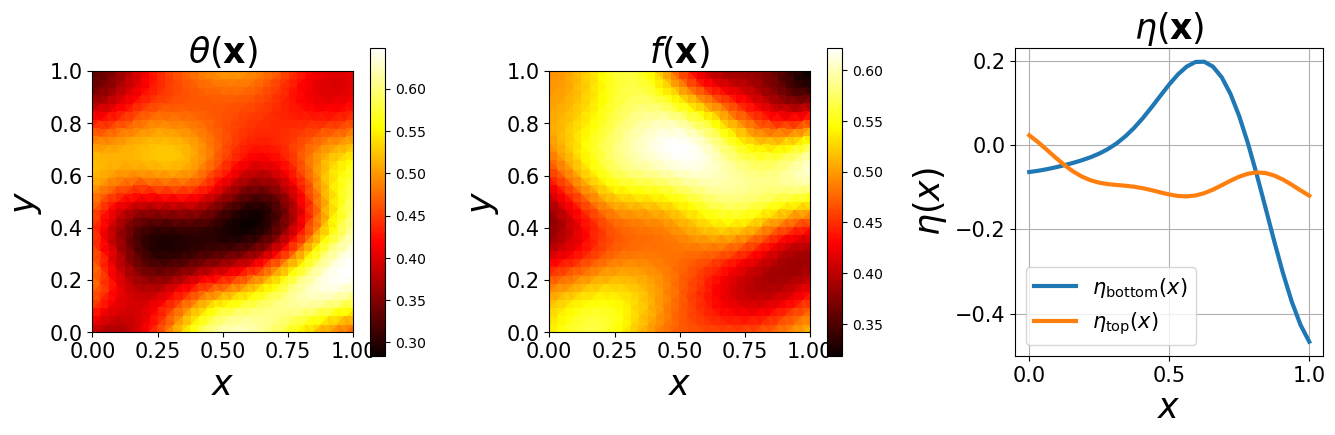

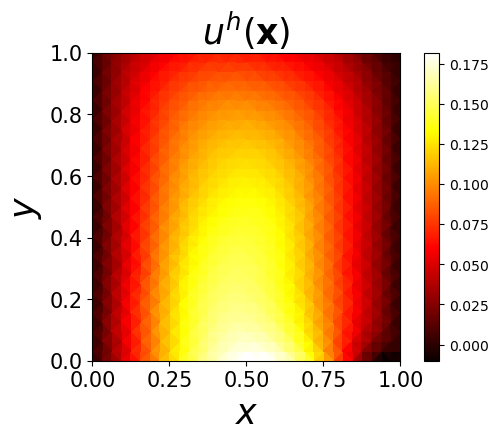

In [329]:
x = outputs['x']
u = outputs['u']
f = outputs['f']
theta = outputs['theta']
etab = outputs['etab']
etat = outputs['etat']

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 25

ax = axs[0]
plot0 = ax.tripcolor(x[:,0], x[:,1], theta, cmap='hot')
ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.tripcolor(x[:,0], x[:,1], f, cmap='hot')
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]

ax.plot(x[x[:,1]==0,0], etab[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', linewidth=3)
ax.plot(x[x[:,1]==1,0], etat[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', linewidth=3)
ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
# ax.set_xlim(0,1)
ax.legend(fontsize=15)
ax.set_box_aspect(1)
ax.grid()

# plt.savefig("hc2d_theta_f_eta.svg", bbox_inches='tight', transparent=True)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x[:,0], x[:,1], u, cmap='hot')
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u.pdf", bbox_inches='tight')

In [330]:
data_postprocessed = postprocessdata(params, inputs, sample, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

In [31]:
from VarMiON import VarMiON
from RegularNN import RegularNN
from NGO import NGO

logdir = '../../../nnlogs'
sublogdir = 'NGO_theta05'
map_location = 'cpu'

model = loadmodelfromlabel(model=NGO, label='halfprecision', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

In [11]:
x = outputs['x']
u = outputs['u']
u_hat = model.simforward(Theta, F, N, x)
# u_hat = model.simforward(Theta, F, N, x).detach().numpy()

# mus = model.mus[0].detach().numpy()
# sigmas = torch.exp(model.log_sigmas[0]).detach().numpy()

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 23
size_ticklabels = 12
size_axeslabels = 25

ax = axs[0]
fig = ax.tripcolor(x[:,0], x[:,1], u, cmap='hot')
ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat, cmap='hot', vmin=np.amin(u), vmax=np.amax(u))
# for i in range(72):
#     ax.scatter(mus[i,0], mus[i,1], s=50, alpha=0.5, color='blue')
#     ax.scatter(mus[i,0], mus[i,1], s=10000*sigmas[i], alpha=0.1, color='C0')
ax.set_title(r"$u^{\mathrm{pred}}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[2]
fig = ax.tripcolor(x[:,0], x[:,1], np.sqrt((u_hat - u)**2)/np.average(np.sqrt(u**2)))
ax.set_title(r"$||u^{\mathrm{pred}} - {u}||_{2}/||u||_{2}$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("prediction.svg", bbox_inches='tight', transparent=True)

L2 = np.average(np.sqrt((u_hat - u)**2))
L2_scaled = L2/np.average(np.sqrt(u**2))
print(L2_scaled)
# APE = np.abs((u_hat - u)/u)
# APE[APE==np.inf] = np.nan
# MAPE = np.nanmean(APE)
# print('MAPE: '+(str(MAPE)))
# # plt.savefig("nonzeroN.pdf", bbox_inches='tight')

NameError: name 'outputs' is not defined

In [284]:
x = outputs['x']
u = outputs['u']
u_hat = model.simforward(Theta, F, N, x)
# u_hat = model.simforward(Theta, F, N, x).detach().numpy()

mus = model.mus[0].detach().numpy()
sigmas = torch.exp(model.log_sigmas[0]).detach().numpy()

#plot
fig, axs = plt.subplots(1,2, figsize=(10, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 23
size_ticklabels = 12
size_axeslabels = 25

ax = axs[0]
fig = ax.tripcolor(x[:,0], x[:,1], u, cmap='hot')
ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat, cmap='hot', vmin=np.amin(u), vmax=np.amax(u))
for i in range(72):
    ax.scatter(mus[i,0], mus[i,1], s=50, alpha=0.5, color='blue')
    ax.scatter(mus[i,0], mus[i,1], s=10000*sigmas[i], alpha=0.1, color='C0')
ax.set_title(r"$u^{\mathrm{pred}}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("NOMADpred3.svg", bbox_inches='tight', transparent=True)

L2 = np.average(np.sqrt((u_hat - u)**2))
L2_scaled = L2/np.average(np.sqrt(u**2))
print(L2_scaled)
# APE = np.abs((u_hat - u)/u)
# APE[APE==np.inf] = np.nan
# MAPE = np.nanmean(APE)
# print('MAPE: '+(str(MAPE)))
# # plt.savefig("nonzeroN.pdf", bbox_inches='tight')

AttributeError: 'VarMiON' object has no attribute 'mus'

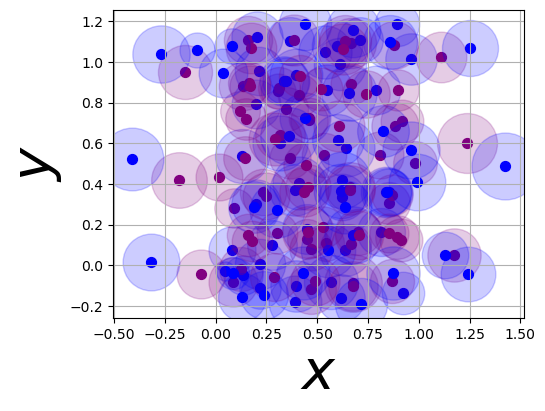

In [43]:
size_title = 25
size_ticklabels = 10
size_axeslabels = 40

mus_NGO = model.Trunk_trial.mus.detach().numpy()
sigmas_NGO = torch.exp(model.Trunk_trial.log_sigmas).detach().numpy()

# mus = model.mus[0].detach().numpy()
# sigmas = torch.exp(model.log_sigmas[0]).detach().numpy()

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for i in range(72):
    ax.scatter(mus_VarMiON[i,0], mus_VarMiON[i,1], s=50, alpha=1, color='blue', label='VarMiON')
    ax.scatter(mus_VarMiON[i,0], mus_VarMiON[i,1], s=10000*sigmas_VarMiON[i], alpha=0.2, color='blue')
    ax.scatter(mus_NGO[i,0], mus_NGO[i,1], s=50, alpha=1, color='purple', label='NGO')
    ax.scatter(mus_NGO[i,0], mus_NGO[i,1], s=10000*sigmas_NGO[i], alpha=0.2, color='purple')
# ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
# ax.set_xlim(-0.5,1.5)
# ax.set_ylim(-0.5,1.5)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
ax.grid()
# ax.legend(fontsize=12)

plt.savefig("phis_boundedcenters_normbasis.svg", bbox_inches='tight')#, transparent=True)

Text(0.5, 0, '$\\frac{\\sigma}{L/h^{1/d}}$')

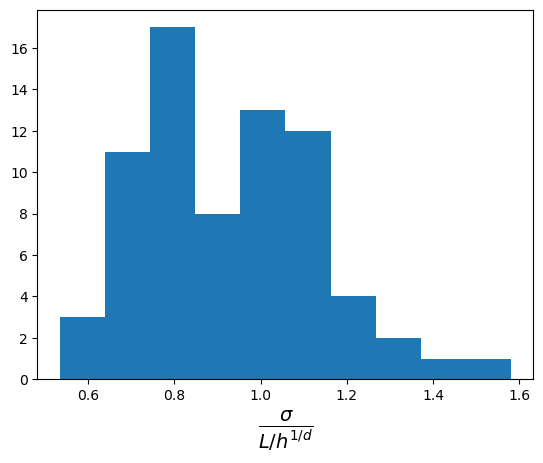

In [23]:
plt.hist(torch.exp(model.Trunk_trial.log_sigmas).detach().numpy()*np.sqrt(72))
plt.xlabel(r'$\frac{\sigma}{L/h^{1/d}}$', fontsize=20)

In [254]:
x = torch.linspace(0,1,100)
y = torch.zeros(100)
x = torch.vstack([x,y]).T
phi = model.Trunk(x[:None,None,:]).squeeze()

TypeError: GaussianRBF_NOMAD.forward() missing 2 required positional arguments: 'log_sigmas' and 'x'

In [57]:
D = model.NLBranch.forward(torch.ones((1,12,12), dtype=model.dtype)).squeeze()

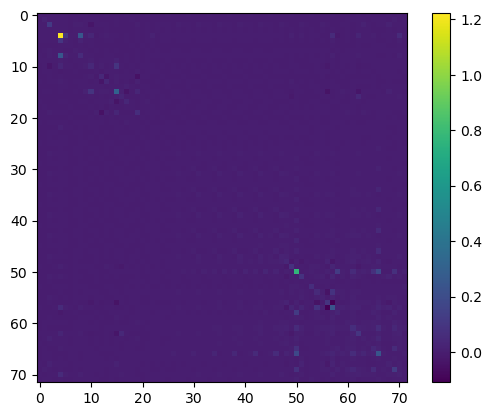

In [58]:
plt.imshow(D.detach().numpy())
plt.colorbar()

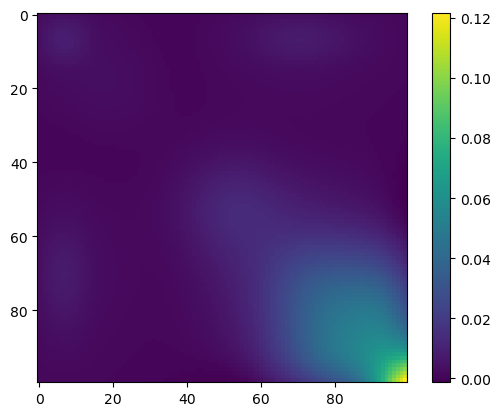

In [60]:
G = torch.einsum('mi,ij,nj->mn', phi, D, phi).detach().numpy()
plt.imshow(G)
plt.colorbar()

### Test score

In [3]:
#Test dataset
N_samples = 1000
Theta_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/Theta.npy'))[:N_samples]
F_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/F.npy'))[:N_samples]
N_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/N.npy'))[:N_samples]
x_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/x.npy'))[:N_samples]
u_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/u.npy'))[:N_samples]

In [4]:
from VarMiON import VarMiON
from RegularNN import RegularNN

model = RegularNN
logdir = '../../../nnlogs'
sublogdir = 'grf'
map_location = 'cpu'
RegularNN = loadmodelfromlabel(model=RegularNN, label='RegularNN', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'grf3'
map_location = 'cpu'

# noLBbias = loadmodelfromlabel(model=model, label='noLBbias', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# noNLBoutputactivation = loadmodelfromlabel(model=model, label='noNLBoutputactivation', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# PosDefSymD = loadmodelfromlabel(model=model, label='SymPosDefD', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# scale_invariant = loadmodelfromlabel(model=model, label='scale_invariant', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# norm_basis = loadmodelfromlabel(model=model, label='norm_basis', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# oneovertheta = loadmodelfromlabel(model=model, label='1overtheta', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
tanhshrink = loadmodelfromlabel(model=model, label='tanhshrink', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# boundedcenters = loadmodelfromlabel(model=model, label='boundedcenters', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# symgroupavg = loadmodelfromlabel(model=model, label='symgroupavg', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges = loadmodelfromlabel(model=model, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# VarMiON = loadmodelfromlabel(model=model, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NOMAD_dot = loadmodelfromlabel(model=model, label='NOMAD_dot', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NOMAD_allchanges = loadmodelfromlabel(model=model, label='NOMAD_allchanges', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges_new = loadmodelfromlabel(model=VarMiON, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'Naive NN': RegularNN}#,
             # 'VarMiON': VarMiON,
             # 'VarMiON+': allchanges,
             #'No bias': noLBbias,
             #'noNLBoutputactivation': noNLBoutputactivation,
            #'SymPosDefD': PosDefSymD,
             #'Scale invariant': scale_invariant,
             #'Normalized basis': norm_basis,
             #'VarMiON': tanhshrink}#,
             #'1overtheta': oneovertheta,
             #'boundedcenters': boundedcenters,
             # 'NOMAD': NOMAD_dot,
             # 'NOMAD+': NOMAD_allchanges}
             #'Extended VarMiON': allchanges_new}

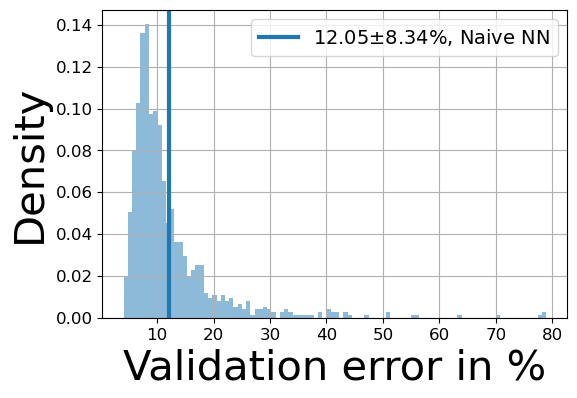

In [7]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 30

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
L2_scaled_avgs = []
i=0
for model in modeldict:
    if modeldict[str(model)].params['hparams']['symgroupavg']==True:
        u_hat = modeldict[str(model)].symgroupavg_forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    else:
        u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    L2 = np.average(np.sqrt((u_hat - u_test.detach().numpy())**2), axis=-1)
    L2_scaled = L2/np.average(np.sqrt((u_test.detach().numpy())**2), axis=-1)
    # APE[np.abs(u_test)<1e-4] = np.nan
    # MAPE = np.nanmean(APE, axis=-1)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(100*L2_scaled, bins=100, density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    ax.axvline(100*L2_scaled_avg, 0, 1, linewidth=3, color=colors[i], label=str(np.around(100*L2_scaled_avg, 2))+r'$\pm$'+str(np.around(100*sigma, 2))+'%, '+str(model))
    i+=1
    L2_scaled_avgs.append(L2_scaled_avg)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,15)
ax.legend(fontsize=14)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
ax.set_xlabel(r'Validation error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
plt.savefig("NaiveNN.svg", bbox_inches='tight')#, transparent=True)

L2_scaled_avgs = np.array(L2_scaled_avgs)
L2_scaled_avg_avg = np.average(L2_scaled_avgs)
std_L2_scaled_avg = np.std(L2_scaled_avgs)
# print(100*L2_scaled_avg_avg)
# print(100*np.amin(L2_scaled_avgs))
# print(100*np.amax(L2_scaled_avgs))
# print(100*std_L2_scaled_avg)